<a href="https://colab.research.google.com/github/jonelrelucio/AN2DL-2025/blob/testing/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import os
from itertools import product



from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from sklearn.metrics import f1_score

SEED = 100

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.8.0+cu126
Device: cpu


In [2]:
df_train = pd.read_csv('pirate_pain_train.csv')

float_cols = df_train.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_train[col] = df_train[col].astype(np.float32)

df_train.head()


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [3]:
df_labels = pd.read_csv('pirate_pain_train_labels.csv')
df_labels.head()



,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [4]:
label_counts = df_labels['label'].value_counts()
display(label_counts)

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [5]:
df_high_pain = df_labels[df_labels['label'] == 'high_pain'].sample(n=56, random_state=SEED)
df_low_pain = df_labels[df_labels['label'] == 'low_pain'].sample(n=56, random_state=SEED)
df_no_pain = df_labels[df_labels['label'] == 'no_pain'].sample(n=56, random_state=SEED)

df_labels_subset = pd.concat([df_high_pain, df_low_pain, df_no_pain])

# Shuffle the subset to mix the categories
df_labels_subset = df_labels_subset.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(df_labels_subset['label'].value_counts())
display(df_labels_subset.head())

label
low_pain     56
no_pain      56
high_pain    56
Name: count, dtype: int64


,sample_index,label
0,265,low_pain
1,558,low_pain
2,547,no_pain
3,617,no_pain
4,386,high_pain


In [6]:
df_merged = pd.merge(df_train, df_labels, on='sample_index')
display(df_merged.head())

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


In [7]:
nan_counts = df_merged.isnull().sum()
display(nan_counts[nan_counts > 0])

,0


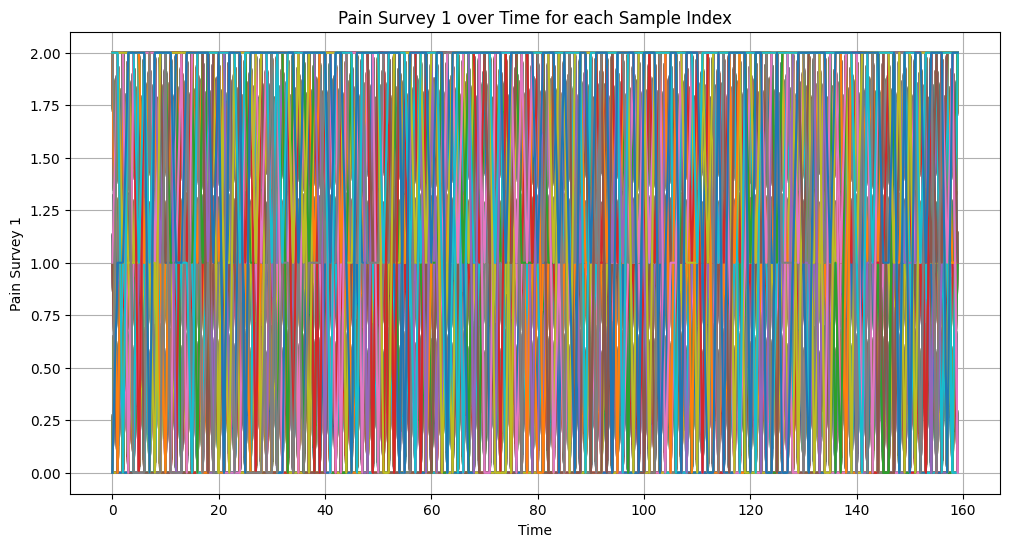

In [ ]:
plt.figure(figsize=(12, 6))
for sample_idx in df_merged['sample_index'].unique():
    subset = df_merged[df_merged['sample_index'] == sample_idx]
    plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for each Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

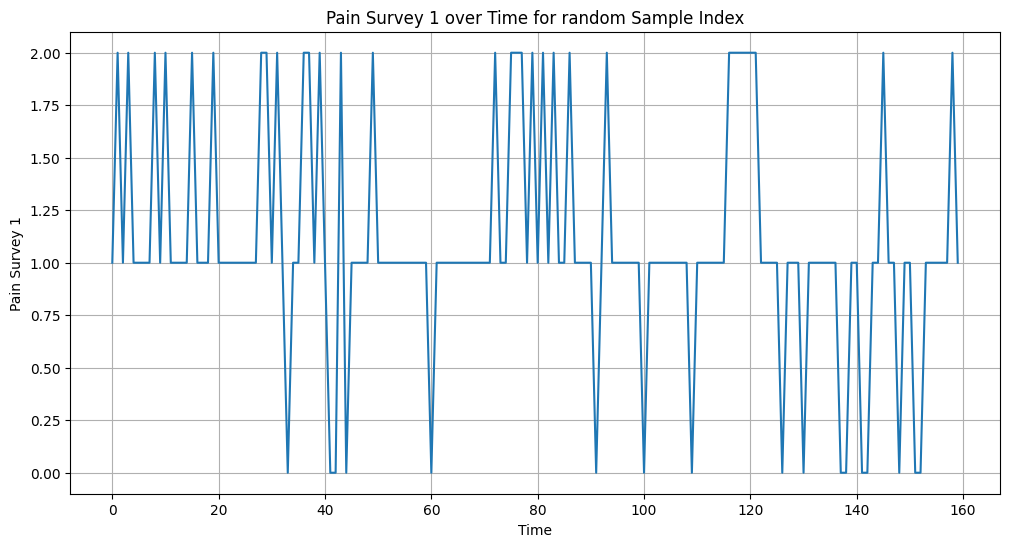

In [8]:
plt.figure(figsize=(12, 6))
sample_idx = random.choice(df_merged['sample_index'].unique())
subset = df_merged[df_merged['sample_index'] == sample_idx]
plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for random Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

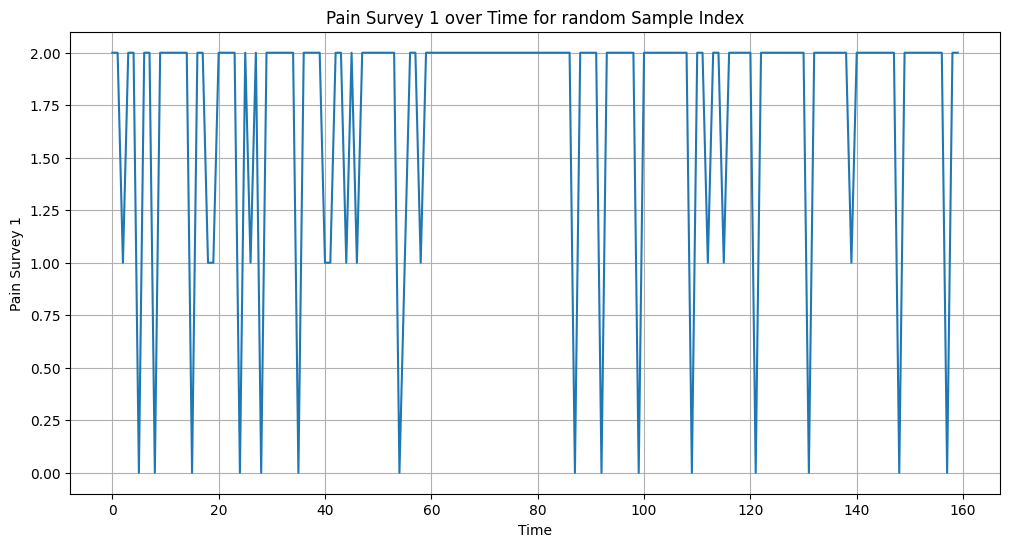

In [9]:
plt.figure(figsize=(12, 6))
sample_idx = random.choice(df_merged['sample_index'].unique())
subset = df_merged[df_merged['sample_index'] == sample_idx]
plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for random Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

In [10]:
label_counts = df_merged['n_legs'].value_counts()
display(label_counts)

,count
n_legs,
two,104800
one+peg_leg,960


In [11]:
label_counts = df_merged['n_eyes'].value_counts()
display(label_counts)

,count
n_eyes,
two,104800
one+eye_patch,960


In [12]:
label_counts = df_merged['n_hands'].value_counts()
display(label_counts)

,count
n_hands,
two,104800
one+hook_hand,960


In [13]:
unusual_samples = df_merged[
    (df_merged['n_eyes'] != 'two') |
    (df_merged['n_legs'] != 'two') |
    (df_merged['n_hands'] != 'two')
]

display(unusual_samples[['sample_index', 'label']].drop_duplicates().reset_index(drop=True))

,sample_index,label
0,8,no_pain
1,137,no_pain
2,216,no_pain
3,338,low_pain
4,350,no_pain
5,496,no_pain


In [ ]:
unusual_sample_indices = unusual_samples['sample_index'].unique()
unusual_labels = df_labels[df_labels['sample_index'].isin(unusual_sample_indices)]

display(unusual_labels)

,sample_index,label
8,8,no_pain
137,137,no_pain
216,216,no_pain
338,338,low_pain
350,350,no_pain
496,496,no_pain


In [ ]:
df_unusual_first_timestamp = df_merged[
    (df_merged['sample_index'].isin(unusual_sample_indices)) &
    (df_merged['time'] == 0)
]
display(df_unusual_first_timestamp.head())

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
1280,8,0,2,2,2,2,one+peg_leg,one+hook_hand,one+eye_patch,1.044719,...,6.372409e-07,4.913076e-07,1.275396e-06,1.013391e-04,0.006518,0.009533,0.021116,0.036020,0.5,no_pain
21920,137,0,2,1,2,2,one+peg_leg,one+hook_hand,one+eye_patch,0.550904,...,1.548532e-07,3.536312e-06,1.374932e-05,4.301242e-07,0.011403,0.026472,0.025387,0.093144,0.5,no_pain
34560,216,0,2,2,2,0,one+peg_leg,one+hook_hand,one+eye_patch,1.028144,...,1.039661e-06,1.022973e-06,3.085185e-07,0.000000e+00,0.019886,0.007193,0.026818,0.029318,0.5,no_pain
54080,338,0,1,2,2,2,one+peg_leg,one+hook_hand,one+eye_patch,0.918924,...,2.666199e-05,1.560968e-05,2.611849e-06,7.306790e-06,0.163500,0.167887,0.045214,0.071361,0.5,low_pain
56000,350,0,2,2,2,2,one+peg_leg,one+hook_hand,one+eye_patch,0.817612,...,2.022018e-07,2.342992e-06,1.193046e-07,4.025079e-05,0.007853,0.015515,0.042245,0.066253,0.5,no_pain


In [16]:
df_test = pd.read_csv('/content/drive/MyDrive/ANN/pirate_pain_test.csv')

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  int64  
 3   pain_survey_2  211840 non-null  int64  
 4   pain_survey_3  211840 non-null  int64  
 5   pain_survey_4  211840 non-null  int64  
 6   n_legs         211840 non-null  object 
 7   n_hands        211840 non-null  object 
 8   n_eyes         211840 non-null  object 
 9   joint_00       211840 non-null  float64
 10  joint_01       211840 non-null  float64
 11  joint_02       211840 non-null  float64
 12  joint_03       211840 non-null  float64
 13  joint_04       211840 non-null  float64
 14  joint_05       211840 non-null  float64
 15  joint_06       211840 non-null  float64
 16  joint_07       211840 non-null  float64
 17  joint_08       211840 non-nul

In [18]:
df_test.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,...,211840.000000,211840.000000,2.118400e+05,2.118400e+05,211840.000000,211840.000000,211840.000000,211840.000000,211840.000000,211840.0
mean,661.500000,79.500000,1.615384,1.665625,1.657501,1.663293,0.984106,1.002312,0.833719,0.839993,...,0.000032,0.000024,4.138805e-05,3.408469e-05,0.000107,0.040524,0.060134,0.052490,0.061218,0.5
std,382.206671,46.187228,0.703560,0.659999,0.666037,0.662678,0.204744,0.191175,0.298458,0.298573,...,0.001464,0.000413,5.570593e-04,6.285418e-04,0.001203,0.057234,0.078081,0.058698,0.066651,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036813,0.014754,0.047624,...,0.000002,0.000001,0.000000e+00,0.000000e+00,0.000000,0.000000,0.004475,0.004083,0.000000,0.5
25%,330.750000,39.750000,1.000000,2.000000,2.000000,2.000000,0.867980,0.897176,0.625202,0.604872,...,0.000003,0.000003,4.412668e-07,2.325231e-07,0.000000,0.010886,0.017376,0.020317,0.021007,0.5
50%,661.500000,79.500000,2.000000,2.000000,2.000000,2.000000,1.040931,1.063110,0.969119,0.979624,...,0.000004,0.000004,2.527479e-06,2.060598e-06,0.000006,0.022146,0.033317,0.035334,0.038696,0.5
75%,992.250000,119.250000,2.000000,2.000000,2.000000,2.000000,1.128461,1.139088,1.052242,1.060542,...,0.000006,0.000006,4.590578e-06,3.708785e-06,0.000014,0.046722,0.069825,0.061336,0.077690,0.5
max,1323.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.500341,1.499030,1.346970,1.333893,...,0.389906,0.062781,6.476609e-02,1.249919e-01,0.167318,1.299322,1.375895,1.412636,1.333794,0.5


In [19]:
df_test['sample_index'].nunique()

1324

In [27]:
unusual_samples = df_test[
    (df_test['n_eyes'] != 'two') |
    (df_test['n_legs'] != 'two') |
    (df_test['n_hands'] != 'two')
]

print(unusual_samples[['sample_index']].nunique())

df_unusual_first_timestamp = df_test[
    (df_test['sample_index'].isin(unusual_sample_indices)) &
    (df_test['time'] == 0)
]
display(df_unusual_first_timestamp[['sample_index', 'n_legs', 'n_hands', 'n_eyes']])

sample_index    13
dtype: int64


,sample_index,n_legs,n_hands,n_eyes
20000,125,one+peg_leg,one+hook_hand,one+eye_patch
29760,186,one+peg_leg,one+hook_hand,one+eye_patch
36160,226,one+peg_leg,one+hook_hand,one+eye_patch
44320,277,one+peg_leg,one+hook_hand,one+eye_patch
94560,591,one+peg_leg,one+hook_hand,one+eye_patch
123040,769,one+peg_leg,one+hook_hand,one+eye_patch
132000,825,one+peg_leg,one+hook_hand,one+eye_patch
142240,889,one+peg_leg,one+hook_hand,one+eye_patch
156160,976,one+peg_leg,one+hook_hand,one+eye_patch
170880,1068,one+peg_leg,one+hook_hand,one+eye_patch
